# Goal
- Filter for data around focus regions (Reservoirs.shp)
- Plot each focus point's level differences

In [4]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# Config
reservoir_fpath_shapefile = './res/Reservoirs.shp'
swot_points_fpath_geojson = './data/output/subset_class3and4_2022_2024_20250124191413.geojson'
save_fpath_geojson = './res/swot_points_reservoirs.geojson'

save_file = False


In [6]:
# Load data
reservoir = gpd.read_file(reservoir_fpath_shapefile)
swot_points = gpd.read_file(swot_points_fpath_geojson)

# Reproject to metric CRS
reservoir = reservoir.to_crs(epsg=3857)
swot_points = swot_points.to_crs(epsg=3857)

# Draw a buffer of 200m around reservoirs
reservoir_buffer = reservoir.buffer(200)
reservoir_buffer = gpd.GeoDataFrame(geometry=reservoir_buffer)

# Keep only the swot points that are within the buffer
swot_points_in_buffer = gpd.sjoin(swot_points, reservoir_buffer, predicate='within')

# Save the result
if save_file == True:
    swot_points_in_buffer.to_file(save_fpath_geojson, driver='GeoJSON')

# Make sure everything worked
if swot_points_in_buffer.shape[0] == 0:
    print('No SWOT points found within reservoirs')

In [7]:
# Convert gpd to pd dataframe
swot_points_in_buffer_pd_dataframe = pd.DataFrame(swot_points_in_buffer)

# save to csv
swot_points_in_buffer_pd_dataframe.to_csv('./data/output/swot_points_in_reservoirs.csv', index=False)

In [8]:
# save to geojson
swot_points_in_buffer.to_file('./data/output/swot_points_in_reservoirs.geojson', driver='GeoJSON')

# Inspect data using Matplotlib
Now that we have the data for each reservoir, we can use the index_right column to average the level differences for each reservoir.

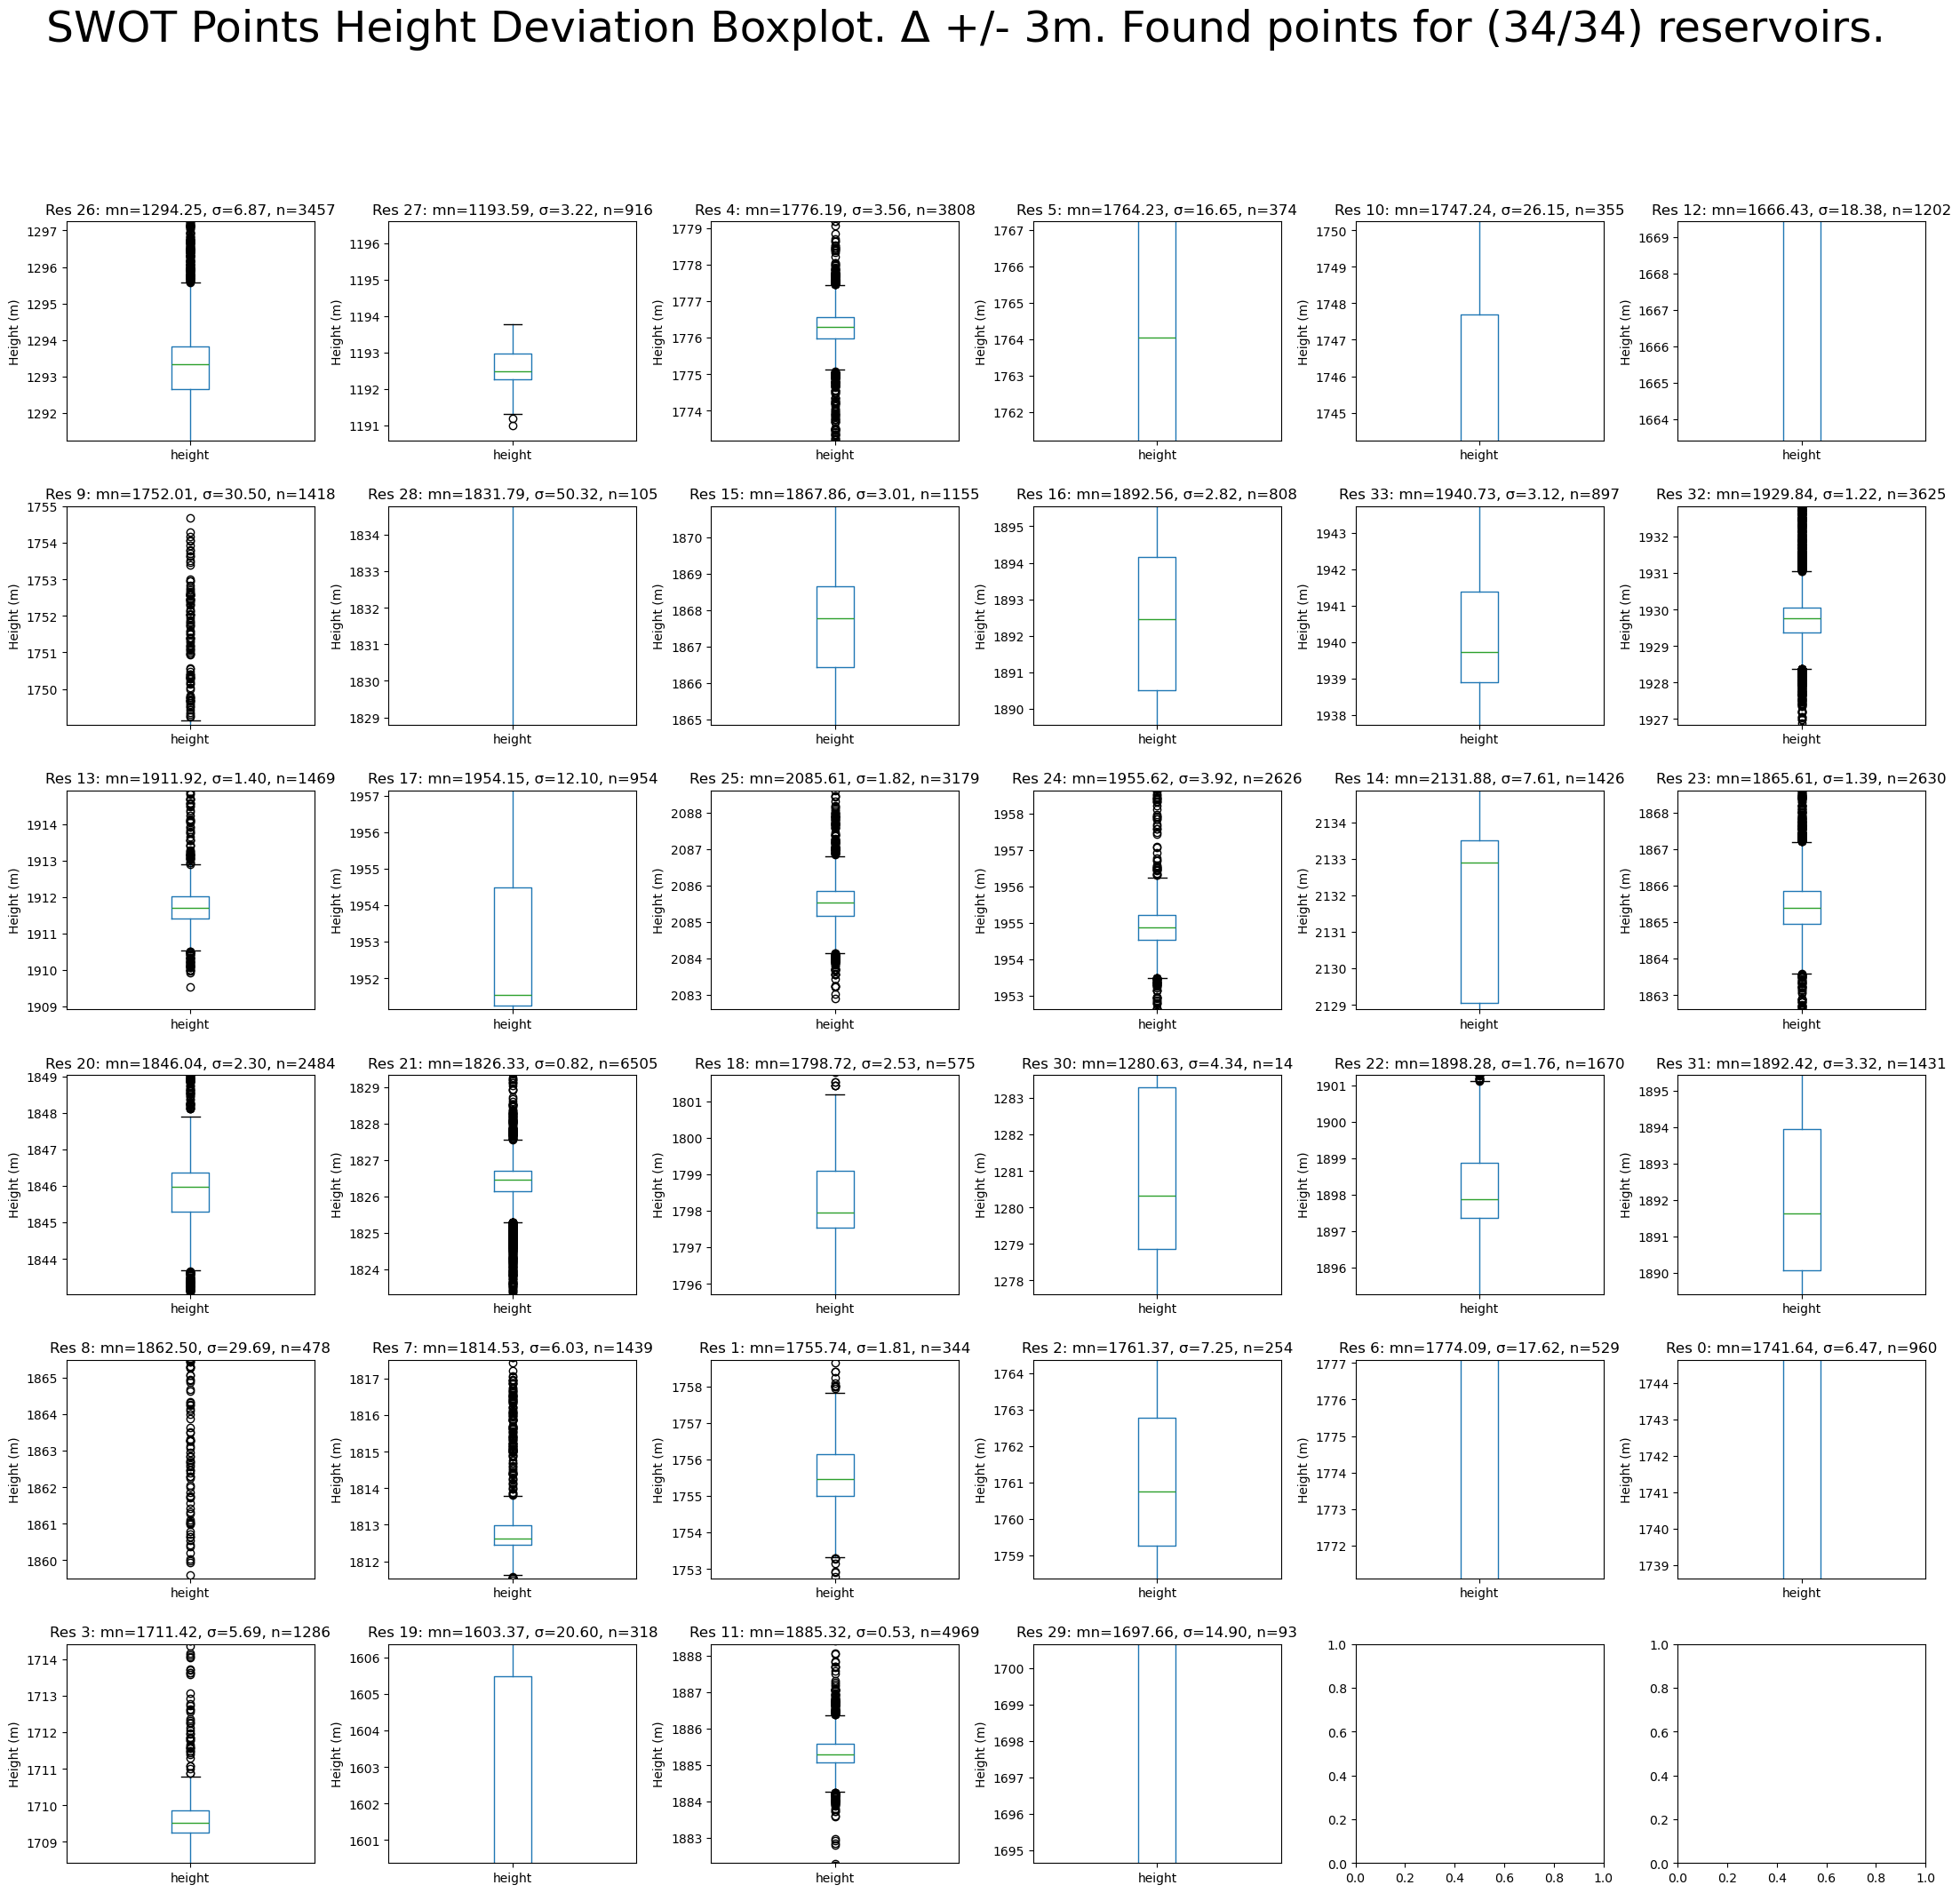

In [9]:
# Get unique reservoirs
reservoirs = swot_points_in_buffer_pd_dataframe['index_right'].unique()

# Create subplots with 6 subplots per row
nrows = len(reservoirs) // 6 + 1
fig, axes = plt.subplots(nrows=nrows, ncols=6, figsize=(27, nrows * 4))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Count the number of reservoirs with data
n_reservoirs_with_data = 0

# Plot each reservoir
for ax, reservoir_id in zip(axes, reservoirs):
    try:
        # Filter data for the current reservoir
        reservoir_data = swot_points_in_buffer[swot_points_in_buffer['index_right'] == reservoir_id]
        
        # Calculate mean and standard deviation of height
        mean_height = reservoir_data['height'].mean()
        std_height = reservoir_data['height'].std()

        # Plot boxplot
        reservoir_data.boxplot(column='height', ax=ax, grid=False)

        # Set axis limits
        ax.set_ylim(mean_height - 3, mean_height + 3)

        # Increment counter
        n_reservoirs_with_data += 1

        # Set labels and title
        #ax.set_xlabel('Reservoir')
        ax.set_ylabel('Height (m)')
        ax.set_title(f'Res {reservoir_id}: mn={mean_height:.2f}, σ={std_height:.2f}, n={len(reservoir_data)}')
        fig.subplots_adjust(hspace=0.3, wspace=0.3)
    except:
        print(f"Error plotting reservoir {reservoir_id}. Likely no data available.")
        pass

# Set the title
fig.suptitle(f'SWOT Points Height Deviation Boxplot. Δ +/- 3m. Found points for ({n_reservoirs_with_data}/{len(reservoir.index)}) reservoirs.', fontsize=35)

# save the plot
plt.savefig('./res/swot_points_reservoirs_deviation_boxplot.png', dpi=150)
